# How to incorporate new regions?

This notebook aims at providing a preliminary overview about how to add new regions beyond the African continent.

## Guideline to extend the model to other regions

There are certain things we would recommend when you think about extending the model to another region. To help you progressing fast, we created this guideline.

- **Debug from the root of rules**

The snakemake workflow can be imagines as tree. It has roots (rules without dependencies), that streamline over the tree trunk (rules that have dependencies) towards it's crown (rules with no following one). In our example the crown is the optimized network. As you cannot build a house starting with the roof of a house, you should make sure that you build it up from the bottom. So debug from bottom up, from rules without dependencies towards the rules which dependencies you already debugged and until you deserve the crown.

- **Use global data as default**

The first time you extend the model to another region, you should use global data and contribute code in harmony with PyPSA-Africa code. It means, the PyPSA-Africa code grows slowly towards the PyPSA-Earth code. While global data might be sometimes less accurate, it has the great benefit that we stay one community that can build on each others developments. In this sense, **we try to build one code base** that works across the Earth so that your developments help everyone. 

- **Create linkers for country specific data**

The default data might be not always enough for your study purpose. We would encourage you to **create linkers** to replace the global default by the new more accurate data and contribute these linkers to the GitHub repository. For instance, you model North Africa, but have more accurate national weather data available for Egypt. While you use the global default data for all countries you could replace the Egyptian data with the linker. This linkers are not yet developed or tested (01.12.21) - but we have ideas on how to design them. Maybe it's an opportunity for a great contributions? 

- **Python first. Understanding the bottlenecks**

Some people consider Python as slow. **Compiler speed is not really a bottleneck for us**. For instance, building the sector-coupled model in Europe from bottom up (executing all rules) takes about 10-15min, while solving a large optimization problem can take between 12-36 hours. What we really need us to develop as community fast, new and better features. Limiting the coding languages to for all workflows to Python helps people with fast developments.

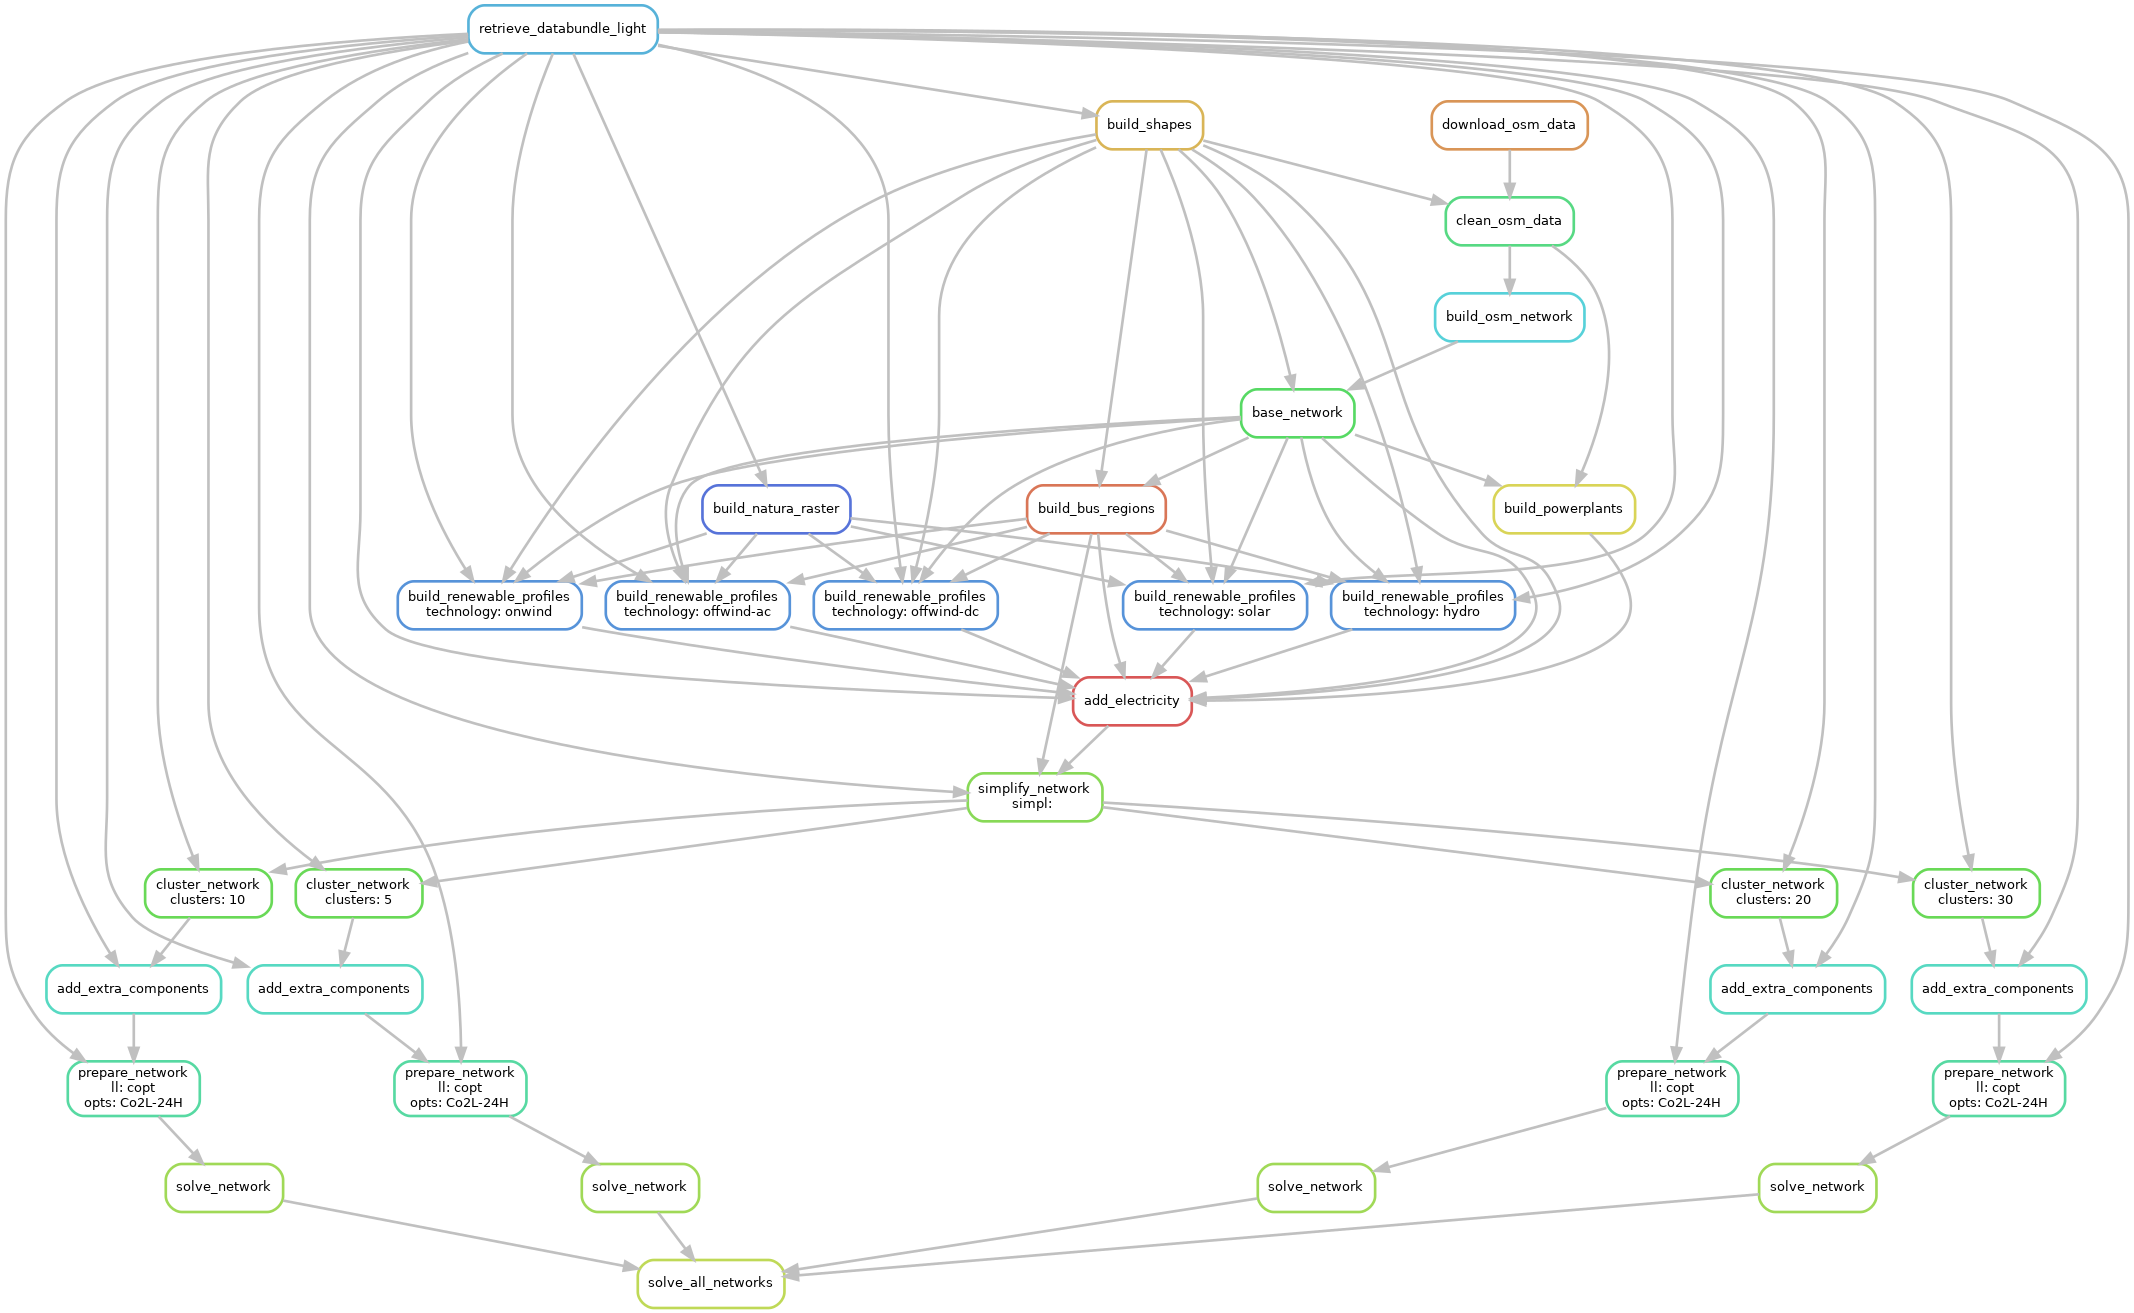

In [1]:
from IPython import display
display.Image("./../../images/hackathon/workflow_example.png")

## 1. The settings

### 1.1. Countries settings

First of all, to change the workflow to perform on a different region, the `config.yaml` file shall be modified to the desired countries.

For example, to perform the workflow on Turkey, the keyword shall be changed as follows:
``` python
    countries = ["TR"]
```

### 1.2. Demand settings

In the snakefile, there is the need to change the demand source to the selected region; the reason is described as follows.

Currently, we used [GlobalEnergyGIS](https://github.com/niclasmattsson/GlobalEnergyGIS) method to estimate the demand for Africa. However, currently, the packages is not written in Python, thus it cannot be easily added as a dependency of the entire workflow.
To overcome this problem, off-line, we executed the tool for the areas of interest: Africa, Asia, Europe and South America, and the data are stored in the folder `resources/ssp2-2.6`

![GEGIS data](./images/gegis_data.png "GEGIS data")

Such data are inputs for the rule `add_electricity` as shown below
``` python
rule add_electricity:
    input:
        base_network='networks/base.nc',
        tech_costs=COSTS,
        regions="resources/regions_onshore.geojson",
        powerplants='resources/powerplants.csv',
        # hydro_capacities='data/bundle/hydro_capacities.csv',
        # geth_hydro_capacities='data/geth2015_hydro_capacities.csv',

        load='resources/ssp2-2.6/2030/era5_2013/Africa.nc',  # CHANGE THIS INPUT, e.g. into 'resources/ssp2-2.6/2030/era5_2013/Asia.nc'

        gadm_shapes='resources/gadm_shapes.geojson',
        **{f"profile_{tech}": f"resources/profile_{tech}.nc"
            for tech in config['renewable']}
    output: "networks/elec.nc"
    log: "logs/add_electricity.log"
    benchmark: "benchmarks/add_electricity"
    threads: 1
    resources: mem=3000
    script: "scripts/add_electricity.py"
```

It is worth noticing the line where the keyword `load` is specified.
When different regions shall be considered, the input value shall be changed accordingly.
``` python
rule add_electricity:
    input:
        load='resources/ssp2-2.6/2030/era5_2013/Africa.nc',  # CHANGE THIS INPUT, e.g. into 'resources/ssp2-2.6/2030/era5_2013/Asia.nc'
```

**Note** in the future, this "hard-coded" approach will be changed programmatically also to accommodate countries located across multiple regions

## 2. Input files

### 2.1. Introduction

The current input files have been tested on the African countries, thus, for other regions appropriate input data may be missing and may be added or replaced.

In particular, in the current workflow some input files needed are automatically downloaded from the original sources by countries according to the list of countries provided by the keyword `countries` in the file `config.yaml`. Some examples are the osm data, downloaded by the rule `download_osm_data` or the GADM shapes, by the rule `build_shapes`.

Other data, instead, cannot be automatically downloaded from the original source, instead, we prepared a databundle (zip files) that are automatically downloaded from google drive. **However, this databundle has been tested for Africa and may be incomplete for other regions**. The input data contained in these files are those where attention should be put when the user is interested into investigating different regions

The input data that shall be investigate are contained in the folders `data/raw`, `resources` and `cutouts`. In particular, we provide below some comments about what are the files that shall be investigated.

Below, we add comments about each folder and the files that shall be addressed:

### 2.2. Folder `data/raw`

- `data/raw/hydrobasins`: in this folder the data about the shapes of watershed boundaries and basins are provided, but the current file in the databundle is Africa-specific. Data for other regions are available from [HydroBASINS](https://www.hydrosheds.org/page/hydrobasins). These data shall be calibrated when hydro resource is used.
- `data/raw/landcover`: data for Africa-only have been downloaded to reduce the needed space; these files shall be changed according to the areas of interest. Data downloaded from the following [link](https://www.protectedplanet.net/en/thematic-areas/wdpa?tab=WDPA)

**No changes expected**
- `data/raw/copernicus`: data with global extension
- `data/raw/eez`: global marittime data already loaded
- `data/raw/gadm`: data downloaded with global scope from build_shapes rule
- `data/raw/GDP`: data already with global scope
- `data/raw/gebco`: data already with global scope
- `data/raw/worldpop`: data automatically downloaded from build_shapes rule

### 2.3. Folder `resources`

The resources folder contains main inputs for the resource and load estimation.

No changes are expected; except for the demand data, all the other files are generated automatically by the workflow.

### 2.4. Folder `cutouts`

The folder `cutouts` contains the cutouts files that contains timeseries of the renewable production for the region of interest, which are generated using [Atlite](https://github.com/PyPSA/atlite).
Currently, you can find a pre-compiled file already built for Africa, for simplicity; however, if a different region shall be investigated, then the file has to be generated for the specific region.

To do so, it is possible to use the rule `build_cutout` that is generally disabled for simplicity, which automatically generates the cutout for the selected regions by usign Atlite. To enable it, you shall go into the `config.yaml` file and change the corresponding boolean value in the `enable` section

``` python
enable:
  build_cutout: true
```

Be aware that, in order to use build_cutout, it is needed to have:

- installed the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu) `cdsapi` package  (`install with pip`) and
- registered and setup your CDS API key as described [on their website](https://cds.climate.copernicus.eu/api-how-to);
  the CDS API allows an automatic filedownload by executing this script

**Once the build_cutout has been executed, we recommend to disable it, once the files have been generated.** Be aware that the cutouts file are very large.